## Dataset Introduction

Link: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

Features:

- ```Age```
- ```Sex```
- ```ChestPainType```
- ```RestingBP```
- ```Cholesterol```
- ```FastingBS```
- ```RestingECG```
- ```MaxHR```
- ```ExerciseAngina```
- ```Oldpeak```
- ```ST_Slope```

Target:
- ```HeartDisease```

### Download Dataset

In [1]:
!kaggle datasets download -d fedesoriano/heart-failure-prediction

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
License(s): ODbL-1.0




  0%|          | 0.00/8.56k [00:00<?, ?B/s]
100%|██████████| 8.56k/8.56k [00:00<?, ?B/s]


## Import Required Libraries

In [2]:
import os
import math
import numpy as np
import pandas as pd
import zipfile as zf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

## Data Loading

### Extract Zip File

In [3]:
def move_extract_and_rename_csv(zip_path, extract_to='../', new_csv_name='heart_failure_raw.csv'):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    new_zip_path = os.path.join(extract_to, os.path.basename(zip_path))
    os.rename(zip_path, new_zip_path)
    
    with zf.ZipFile(new_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    os.remove(new_zip_path)

    for file in os.listdir(extract_to):
        if file.endswith('.csv'):
            old_csv_path = os.path.join(extract_to, file)
            new_csv_path = os.path.join(extract_to, new_csv_name)
            os.rename(old_csv_path, new_csv_path)
            break

move_extract_and_rename_csv('heart-failure-prediction.zip')

### Load Dataset

In [4]:
df = pd.read_csv('../heart_failure_raw.csv')
df.head(len(df))

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


## Expl(ora/ana)tory Data Analysis

### Data Assesing

In [5]:
def assess_dataframe(df, target=None, high_card_threshold=0.5):
    print("Data Assessment Report")

    n_rows, n_cols = df.shape
    print(f"\nShape of Dataset: {n_rows} Rows x {n_cols} Columns")

    print("\nColumn Information:")
    info_table = pd.DataFrame({
        "DataType": df.dtypes,
        "Non-Null Count": df.notnull().sum(),
        "Null Count": df.isnull().sum(),
        "Null %": (df.isnull().sum() / n_rows * 100).round(2),
        "Unique Values": df.nunique(dropna=True),
        "Unique %": (df.nunique(dropna=True) / n_rows * 100).round(2),
    })
    print(info_table)

    dup_count = df.duplicated().sum()
    dup_percent = round((dup_count / n_rows) * 100, 2) if n_rows else 0.0
    print(f"\nDuplicate Rows: {dup_count} ({dup_percent}%)")

    const_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
    print("\nConstant Columns:")
    print(const_cols if const_cols else "None")

    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    high_card_cols = []
    for c in cat_cols:
        ratio = (df[c].nunique(dropna=True) / n_rows) if n_rows else 0.0
        if ratio >= high_card_threshold:
            high_card_cols.append((c, round(ratio*100, 2)))
    print("\nHigh Cardinality Categorical Columns (>= {:.0f}% Unique):".format(high_card_threshold*100))
    if high_card_cols:
        for c, pct in high_card_cols:
            print(f"- {c}: {pct}% Unique")
    else:
        print("None")

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if num_cols:
        print("\nNumeric Columns Summary:")
        modes = {}
        if len(num_cols) > 0:
            mode_df = df[num_cols].mode(dropna=True)
            for c in num_cols:
                modes[c] = mode_df[c].iloc[0] if not mode_df.empty and c in mode_df else np.nan
        summary = pd.DataFrame({
            "Mean": df[num_cols].mean(numeric_only=True),
            "Median": df[num_cols].median(numeric_only=True),
            "Mode": pd.Series(modes),
            "Min": df[num_cols].min(numeric_only=True),
            "Q1": df[num_cols].quantile(0.25, numeric_only=True),
            "Q3": df[num_cols].quantile(0.75, numeric_only=True),
            "Max": df[num_cols].max(numeric_only=True),
            "Standard Deviation": df[num_cols].std(numeric_only=True),
            "Skewness": df[num_cols].skew(numeric_only=True),
            "Kurtosis": df[num_cols].kurt(numeric_only=True)
        }).round(4)
        print(summary)

        print("\nOutlier Counts (IQR method):")
        outlier_rows = []
        for c in num_cols:
            series = df[c].dropna()
            if series.empty:
                outlier_rows.append((c, 0, 0.0))
                continue
            q1 = series.quantile(0.25)
            q3 = series.quantile(0.75)
            iqr = q3 - q1
            if iqr == 0:
                outlier_rows.append((c, 0, 0.0))
                continue
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            count = ((series < lower) | (series > upper)).sum()
            pct = round(count / len(series) * 100, 2)
            outlier_rows.append((c, int(count), pct))
        if outlier_rows:
            outlier_table = pd.DataFrame(outlier_rows, columns=["Column", "Outliers", "Outliers %"])
            print(outlier_table)

        print("\nPearson Correlation (Numeric):")
        pearson_corr = df[num_cols].corr(method="pearson")
        print(pearson_corr.round(3))

        print("\nSpearman Correlation (Numeric):")
        spearman_corr = df[num_cols].corr(method="spearman")
        print(spearman_corr.round(3))
    else:
        print("\nNo Numeric columns found.")

    print("\nColumns > 50% Missing Values:")
    high_missing = info_table[info_table["Null %"] > 50].sort_values("Null %", ascending=False)
    if not high_missing.empty:
        print(high_missing[["Null Count", "Null %"]])
    else:
        print("None")

    print("\nMemory Usage:")
    total_mem = df.memory_usage(deep=True).sum()
    print(f"Total: {total_mem} bytes ({round(total_mem/1024,2)} KB, {round(total_mem/(1024*1024),2)} MB)")
    memory_per_col = df.memory_usage(deep=True)
    memory_table = pd.DataFrame({"Bytes": memory_per_col}).sort_values("Bytes", ascending=False)
    print("\nPer Column Memory:")
    print(memory_table)

    if target is not None and target in df.columns:
        print(f"\nClass Balance for '{target}':")
        vc = df[target].value_counts(dropna=False)
        vp = df[target].value_counts(normalize=True, dropna=False).mul(100).round(2)
        bal = pd.DataFrame({"Count": vc, "Percent %": vp})
        print(bal)

    print("\nData Assessment Completed")

assess_dataframe(df)

Data Assessment Report

Shape of Dataset: 918 Rows x 12 Columns

Column Information:
               DataType  Non-Null Count  Null Count  Null %  Unique Values  \
Age               int64             918           0     0.0             50   
Sex              object             918           0     0.0              2   
ChestPainType    object             918           0     0.0              4   
RestingBP         int64             918           0     0.0             67   
Cholesterol       int64             918           0     0.0            222   
FastingBS         int64             918           0     0.0              2   
RestingECG       object             918           0     0.0              3   
MaxHR             int64             918           0     0.0            119   
ExerciseAngina   object             918           0     0.0              2   
Oldpeak         float64             918           0     0.0             53   
ST_Slope         object             918           0     0

### Categorical & Numeric Features (Full Lowercase)

In [6]:
df.columns = [col.lower() for col in df.columns]

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.lower()

cat_features = ['sex', 'chestpaintype', 'fastingbs', 'restingecg', 'exerciseangina', 'st_slope', 'heartdisease']
num_features = ['age', 'restingbp', 'cholesterol', 'maxhr', 'oldpeak']
df.head()

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
0,40,m,ata,140,289,0,normal,172,n,0.0,up,0
1,49,f,nap,160,180,0,normal,156,n,1.0,flat,1
2,37,m,ata,130,283,0,st,98,n,0.0,up,0
3,48,f,asy,138,214,0,normal,108,y,1.5,flat,1
4,54,m,nap,150,195,0,normal,122,n,0.0,up,0


### Numeric Distribution

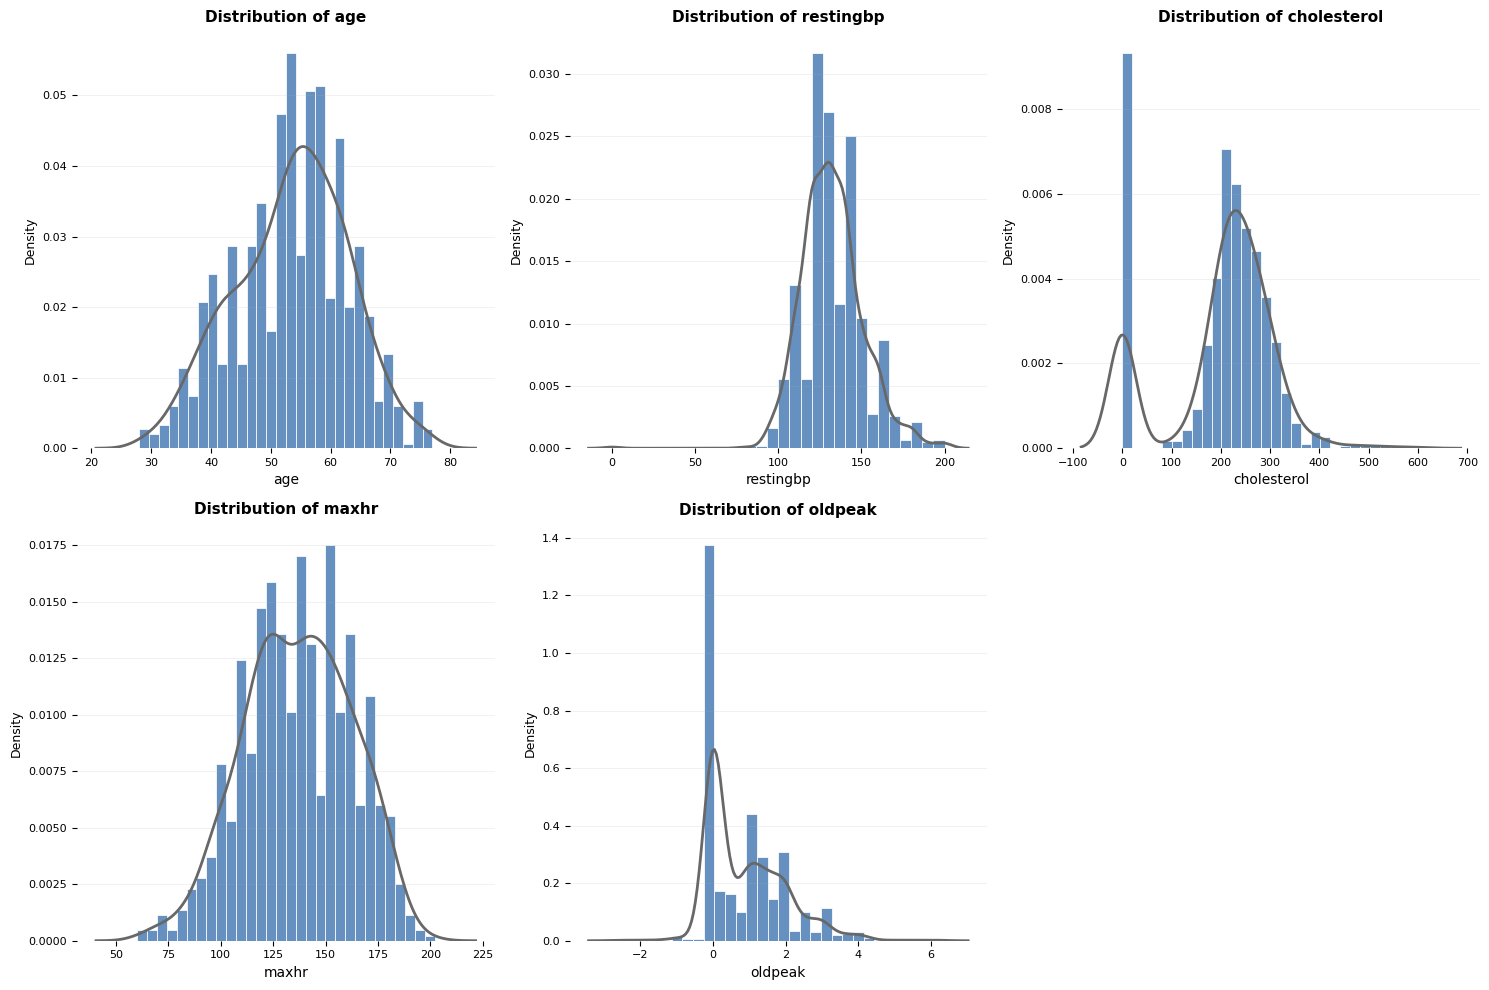

In [7]:
plt.figure(figsize=(15, 10))

cols = 3
rows = int(np.ceil(len(num_features)/cols))

for i, col in enumerate(num_features, 1):
    ax = plt.subplot(rows, cols, i)

    ax.hist(
        df[col].dropna(),
        bins=30,
        density=True,
        color="#5584B9",
        edgecolor="white",
        linewidth=0.6,
        alpha=0.9
    )

    # KDE line in darker blue for contrast
    sns.kdeplot(df[col].dropna(), ax=ax, color="#686868", linewidth=2)
    
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Density", fontsize=9)
    ax.set_title(f"Distribution of {col}", fontsize=11, fontweight="bold", color="#000000", pad=8)

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="y", alpha=0.2, linestyle="-", linewidth=0.6)
    ax.tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()


### Categorical Distributions

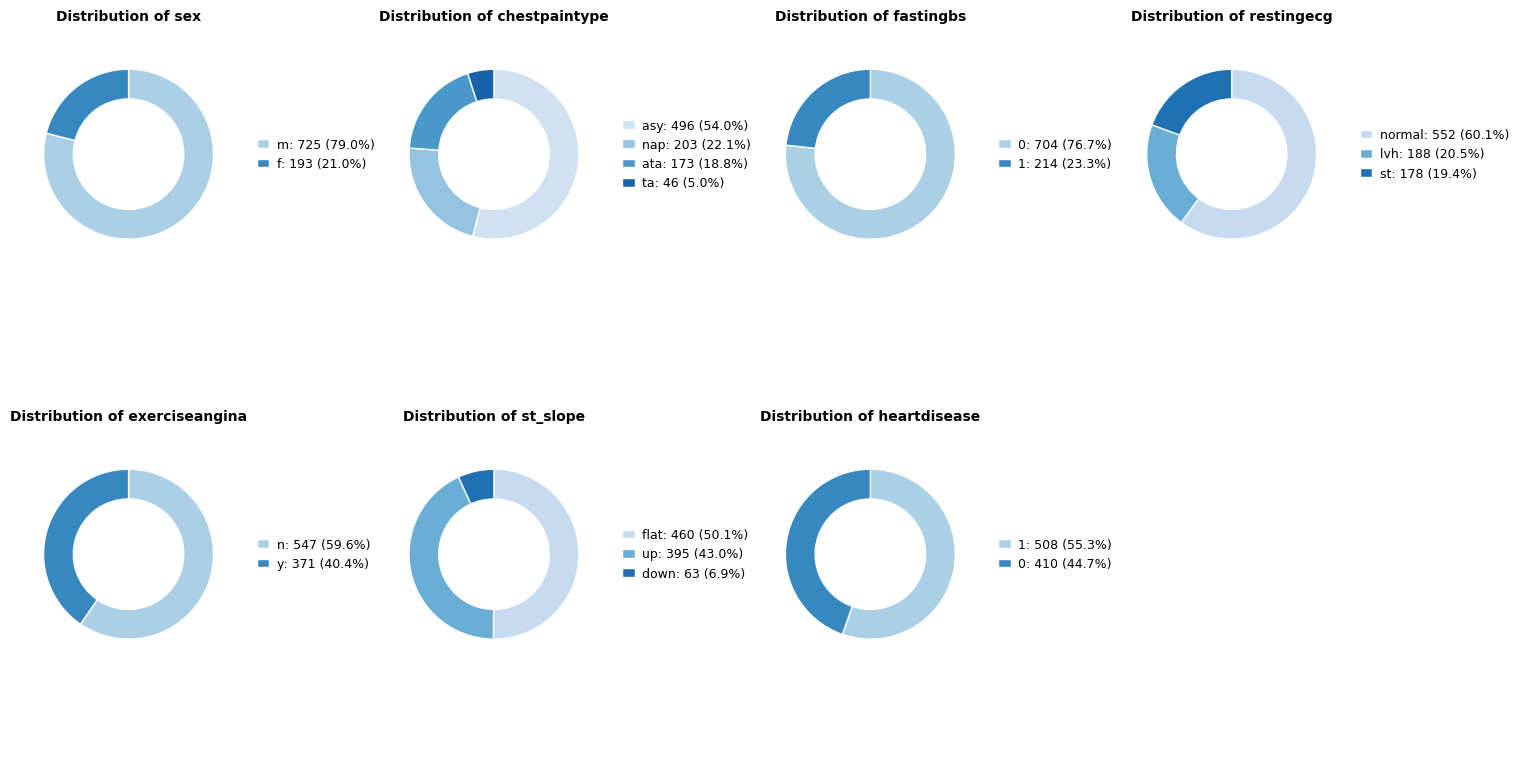

In [8]:
cols = 4
n = len(cat_features)
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 8), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(cat_features):
    ax = axes[i]
    values = df[col].value_counts(dropna=False)
    total = values.sum()
    perc = (values / total * 100).round(1)
    colors = sns.color_palette("Blues", len(values))

    wedges, _ = ax.pie(
        values.values,
        startangle=90,
        counterclock=False,
        radius=1.0,
        wedgeprops=dict(width=0.35, edgecolor="white", linewidth=1),
        colors=colors
    )

    centre_circle = plt.Circle((0, 0), 0.65, color='white', zorder=0)
    ax.add_artist(centre_circle)

    legend_labels = [f"{idx}: {cnt} ({p:.1f}%)" for idx, cnt, p in zip(values.index, values.values, perc)]
    ax.legend(
        wedges,
        legend_labels,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
        fontsize=9,
        handlelength=1,
        handletextpad=0.6
    )

    ax.set_title(f"Distribution of {col}", fontsize=10, fontweight="bold", color="#000000", pad=20)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")

for j in range(i+1, len(axes)):
    axes[j].axis("off")

fig.patch.set_facecolor("white")
plt.show()

### Correlation Matrix

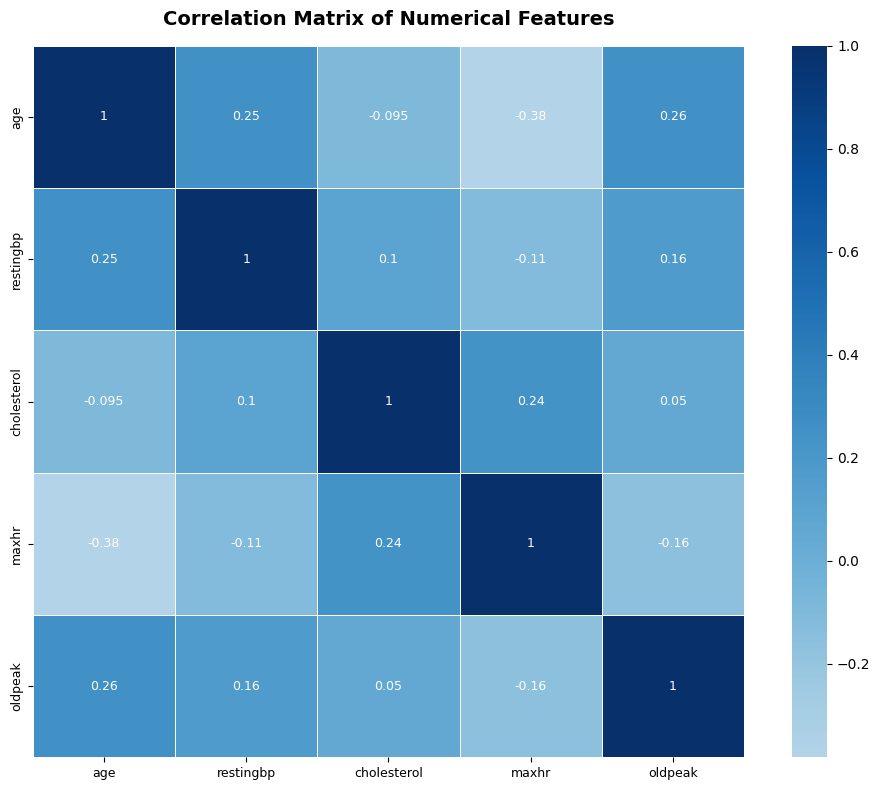

In [9]:
corr = df[num_features].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(
    corr,
    annot=True,
    cmap="Blues",
    center=0,
    square=True,
    cbar=True,
    linewidths=0.5,
    annot_kws={"size": 9, "color": "white"},
)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.title("Correlation Matrix of Numerical Features", fontsize=14, fontweight="bold", color="#000000", pad=15)
plt.xticks(rotation=0, ha="center", fontsize=9)
plt.yticks(rotation=90, fontsize=9)
plt.tight_layout()
plt.show()

## Data Preprocessing

### Label Encoding

In [10]:
categorical_features = ['sex', 'chestpaintype', 'fastingbs', 'restingecg', 'exerciseangina', 'st_slope']

le_dict = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le
df.head()

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


### Data Splitting

In [11]:
X = df.drop('heartdisease', axis=1)
y = df['heartdisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Normalization

In [12]:
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [13]:
X_train.head()

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope
485,0.970012,1,1,0.339016,0.127137,1,2,-0.324520,1,0.317046,1
486,0.122028,1,1,-1.266031,0.099443,1,2,1.689837,0,-0.440356,2
117,0.546020,0,0,-0.159102,1.244113,1,2,-0.247045,1,0.601071,1
361,-0.725956,1,0,1.501291,-1.876035,0,1,-0.479470,1,-0.819056,1
296,-0.407962,1,0,0.671094,-1.876035,1,1,0.101594,1,-0.156330,1


In [14]:
X_test.head()

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope
356,-0.831954,1,0,-0.989299,-1.876035,0,1,-0.905584,1,0.601071,1
763,0.440022,1,2,-0.048409,0.191755,0,0,1.418673,0,2.210549,2
817,0.652018,1,0,-0.435834,0.505616,0,0,0.179069,1,1.831848,1
735,-0.513960,1,2,-0.712567,-0.140568,0,1,0.101594,0,1.074447,1
892,-1.573940,0,2,0.283669,0.154830,0,1,0.605183,0,-0.819056,1


### Save Preprocessed Dataset

In [15]:
if not os.path.exists("./preprocess_data_pkl"):
    os.makedirs("./preprocess_data_pkl")

train_combined = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
test_combined  = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

train_combined.to_csv("./preprocess_dataset/train_preprocessed.csv", index=False)
test_combined.to_csv("./preprocess_dataset/test_preprocessed.csv", index=False)

train_combined.to_pickle("./preprocess_data_pkl/train_preprocessed.pkl")
test_combined.to_pickle("./preprocess_data_pkl/test_preprocessed.pkl")

print("Preprocessed Train and Test Saved Successfully")

Preprocessed Train and Test Saved Successfully
